# ML Quest #1: Demand Forecasting
https://www.patreon.com/ZazenCodes

## Part 3: Forecast

## Sections
1. Load Model and Generate Forecasts
2. Merge Forecast with Past Data
3. Visualize Forecast
4. Upload Predictions to Postgres
5. Dashboard Playground

## Setup

Refer to the Part 1 notebook for setup instructions.

## 1. Load Model and Generate Predictions

In [1]:
from pickle import load
from pathlib import Path

def load_model(model_name, artifact_path="../artifacts"):
    with open(Path(artifact_path) / f"{model_name}.pkl", "rb") as f:
        model = load(f)
    return model
        

model = load_model("boosted_tree")

In [2]:
model

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_split=10,
                          subsample=0.8)

In [3]:
import pandas as pd

In [4]:
!ls ../data

final_week_processed.csv   meal_demand_historical.csv
full_clean_encoded.csv     train_processed.csv


In [5]:
!ls ../artifacts

boosted_tree.pkl               boosted_tree_stack_week_6.pkl
boosted_tree_stack_week_1.pkl  boosted_tree_stack_week_7.pkl
boosted_tree_stack_week_10.pkl boosted_tree_stack_week_8.pkl
boosted_tree_stack_week_11.pkl boosted_tree_stack_week_9.pkl
boosted_tree_stack_week_12.pkl city_name_encoder.pkl
boosted_tree_stack_week_2.pkl  meal_info_encoder.pkl
boosted_tree_stack_week_3.pkl  meal_name_encoder.pkl
boosted_tree_stack_week_4.pkl  price_scaler_encoder.pkl
boosted_tree_stack_week_5.pkl


In [6]:
# Predict next week demand based on final week of data (processed)

df_final_week = pd.read_csv("../data/final_week_processed.csv")

In [7]:
df_final_week

,week_number,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,...,price_diff,month_num,quarter_num,year_num,num_orders_last_year,num_orders_last_week,num_orders_rolling_4_weeks,num_orders_rolling_16_weeks,num_orders_last_year_rolling_4_weeks,num_orders_last_year_rolling_16_weeks
0,145,0,0,121,2.0,0,0,0,1,0,...,0.000000,10,4,3,176.0,162.0,114.75,125.8125,230.50,237.6250
1,145,0,0,54,2.0,1,0,0,0,0,...,-0.006224,10,4,3,258.0,190.0,88.25,144.5625,297.25,279.8125
2,145,0,0,135,2.0,1,0,0,0,0,...,0.012447,10,4,3,175.0,122.0,87.75,135.9375,212.50,206.0000
3,145,0,0,15,2.0,0,0,0,1,0,...,0.000000,10,4,3,26.0,27.0,14.00,22.3125,24.00,22.1875
4,145,0,0,96,2.0,0,0,1,0,0,...,0.000000,10,4,3,26.0,81.0,54.50,76.0000,57.50,47.4375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,145,0,0,68,4.5,1,0,0,0,0,...,0.000000,10,4,3,27.0,123.0,71.50,84.6250,37.25,66.1250
3180,145,0,0,42,4.5,0,1,0,0,0,...,0.000000,10,4,3,28.0,13.0,17.25,34.9375,20.25,27.1875
3181,145,0,0,501,4.5,1,0,0,0,0,...,0.518996,10,4,3,94.0,770.0,415.50,263.3750,236.75,323.0000
3182,145,0,0,729,4.5,0,1,0,0,0,...,0.434664,10,4,3,243.0,811.0,496.75,395.0000,398.00,437.9375


In [8]:
"next_week_num_orders" in df_final_week.columns

False

In [9]:
df_final_week[df_final_week.isnull().any(axis=1)]

,week_number,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,...,price_diff,month_num,quarter_num,year_num,num_orders_last_year,num_orders_last_week,num_orders_rolling_4_weeks,num_orders_rolling_16_weeks,num_orders_last_year_rolling_4_weeks,num_orders_last_year_rolling_16_weeks


In [10]:
from tqdm import tqdm

In [11]:
df_final_week.columns

Index(['week_number', 'emailer_for_promotion', 'homepage_featured',
       'num_orders', 'op_area', 'Meat', 'Other', 'Seafood', 'Vegetarian',
       'beverage', 'dessert', 'main', 'side', 'starter', 'city_id', 'meal_id',
       'base_price_normed', 'checkout_price_normed', 'price_diff', 'month_num',
       'quarter_num', 'year_num', 'num_orders_last_year',
       'num_orders_last_week', 'num_orders_rolling_4_weeks',
       'num_orders_rolling_16_weeks', 'num_orders_last_year_rolling_4_weeks',
       'num_orders_last_year_rolling_16_weeks'],
      dtype='object')

In [12]:
def predict_demand(df_week_x, future_weeks=12):
    y_preds = []
    city_ids = df_week_x.city_id.values
    meal_ids = df_week_x.meal_id.values
    meal_infos = df_week_x[['Meat', 'Other', 'Seafood', 'Vegetarian',
       'beverage', 'dessert', 'main', 'side', 'starter']].values.tolist()

    assert "next_week_num_orders" not in df_week_x.columns
    assert "target_num_orders" not in df_week_x.columns
    X_pred = df_week_x
    initial_week_number = int(df_week_x.week_number.max())
    for future_week_offset in tqdm(list(range(1, future_weeks+1))):
        # 1, 2, 3, ... 12
        pred_week_num = initial_week_number + future_week_offset
        print(f"Predicting for week {pred_week_num}")
        model = load_model(f"boosted_tree_stack_week_{future_week_offset}")
        y_pred = model.predict(X_pred)
        y_preds.extend([{
            "period": "Future",
            "week_number": pred_week_num,
            "num_orders": y,
            "city_id": city_id,
            "meal_id": meal_id,
            "meal_info" : meal_info
        } for y, city_id, meal_id, meal_info in zip(y_pred, city_ids, meal_ids, meal_infos)])
    
    df_preds = pd.DataFrame(y_preds)
    return df_preds


df_future = predict_demand(df_final_week)
df_future

  0%|          | 0/12 [00:00<?, ?it/s]

Predicting for week 146
Predicting for week 147
Predicting for week 148
Predicting for week 149


100%|██████████| 12/12 [00:00<00:00, 113.71it/s]

Predicting for week 150
Predicting for week 151
Predicting for week 152
Predicting for week 153
Predicting for week 154
Predicting for week 155
Predicting for week 156
Predicting for week 157


,period,week_number,num_orders,city_id,meal_id,meal_info
0,Future,146,100.661289,9,50,"[0, 0, 0, 1, 0, 0, 1, 0, 0]"
1,Future,146,75.619518,9,48,"[1, 0, 0, 0, 0, 0, 1, 0, 0]"
2,Future,146,75.978132,9,37,"[1, 0, 0, 0, 0, 0, 1, 0, 0]"
3,Future,146,29.952374,9,8,"[0, 0, 0, 1, 0, 0, 0, 0, 1]"
4,Future,146,51.038318,9,23,"[0, 0, 1, 0, 0, 0, 1, 0, 0]"
...,...,...,...,...,...,...
38203,Future,157,80.122276,33,17,"[1, 0, 0, 0, 0, 0, 1, 0, 0]"
38204,Future,157,39.574436,33,15,"[0, 1, 0, 0, 0, 1, 0, 0, 0]"
38205,Future,157,260.000607,33,41,"[1, 0, 0, 0, 0, 0, 1, 0, 0]"
38206,Future,157,368.016931,33,39,"[0, 1, 0, 0, 0, 1, 0, 0, 0]"


## 2. Merge Forecast with Past Data

In [13]:
import numpy as np

In [14]:
class OrderedCategoryEncoder:
    def __init__(self):
        self.categories_: list[str] = None
        self.category_map: dict[str: int] = None
        self.inverse_category_map: dict[int: str] = None

    def fit(self, ordered_categories: list[str]):
        self.categories_ = ordered_categories
        self.category_map = {category: i+1 for i, category in enumerate(ordered_categories)}
        self.inverse_category_map = {i+1: category for i, category in enumerate(ordered_categories)}

    def transform(self, values: list[str]) -> np.array:
        if set(values) - set(self.category_map):
            for value in values:
                if value not in self.category_map:
                    print(f"'{value}' was not in the fit data")
            raise ValueError("New category found, cannot transform")

        return np.array([self.category_map[value] for value in values])
    
    def inverse_transform(self, values: list[int]) -> np.array:
        if set(values) - set(self.inverse_category_map):
            for value in values:
                if value not in self.inverse_category_map:
                    print(f"'{value}' was not in the fit data")
            raise ValueError("New category found, cannot transform")

        return np.array([self.inverse_category_map[value] for value in values])


In [15]:
import re

def load_encoders(artifact_path="../artifacts"):
    encoders = {}
    for file_path in Path(artifact_path).glob("*encoder.pkl"):
        print(file_path)
        with open(file_path, "rb") as f:
            print(file_path.name)
            encoders[re.findall(r"(.*)_encoder", file_path.name)[0]] = load(f)
    return encoders

encoders = load_encoders()
encoders.keys()

../artifacts/meal_name_encoder.pkl
meal_name_encoder.pkl
../artifacts/city_name_encoder.pkl
city_name_encoder.pkl
../artifacts/price_scaler_encoder.pkl
price_scaler_encoder.pkl
../artifacts/meal_info_encoder.pkl
meal_info_encoder.pkl


dict_keys(['meal_name', 'city_name', 'price_scaler', 'meal_info'])

In [16]:
df_past = pd.read_csv(f"../data/full_clean_encoded.csv")

In [17]:
df_past

,week_number,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,dessert,main,side,starter,city_id,meal_id
0,1,136.83,152.29,0,0,177,2.0,0,0,0,1,0,0,1,0,0,9,50
1,1,136.83,135.83,0,0,270,2.0,1,0,0,0,0,0,1,0,0,9,48
2,1,134.86,135.86,0,0,189,2.0,1,0,0,0,0,0,1,0,0,9,37
3,1,339.50,437.53,0,0,54,2.0,0,0,0,1,0,0,0,0,1,9,8
4,1,243.50,242.50,0,0,40,2.0,0,0,1,0,0,0,1,0,0,9,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446727,145,484.09,484.09,0,0,68,4.5,1,0,0,0,0,0,1,0,0,33,17
446728,145,482.09,482.09,0,0,42,4.5,0,1,0,0,0,1,0,0,0,33,15
446729,145,237.68,321.07,0,0,501,4.5,1,0,0,0,0,0,1,0,0,33,41
446730,145,243.50,313.34,0,0,729,4.5,0,1,0,0,0,1,0,0,0,33,39


In [18]:
df_past["period"] = "Past"

In [19]:
df_past["meal_info"] = [list(item) for item in df_past[['Meat', 'Other',
       'Seafood', 'Vegetarian', 'beverage', 'dessert', 'main', 'side',
       'starter']].values]

In [20]:
df_past.columns

Index(['week_number', 'checkout_price', 'base_price', 'emailer_for_promotion',
       'homepage_featured', 'num_orders', 'op_area', 'Meat', 'Other',
       'Seafood', 'Vegetarian', 'beverage', 'dessert', 'main', 'side',
       'starter', 'city_id', 'meal_id', 'period', 'meal_info'],
      dtype='object')

In [21]:
df_past

,week_number,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,op_area,Meat,Other,Seafood,Vegetarian,beverage,dessert,main,side,starter,city_id,meal_id,period,meal_info
0,1,136.83,152.29,0,0,177,2.0,0,0,0,1,0,0,1,0,0,9,50,Past,"[0, 0, 0, 1, 0, 0, 1, 0, 0]"
1,1,136.83,135.83,0,0,270,2.0,1,0,0,0,0,0,1,0,0,9,48,Past,"[1, 0, 0, 0, 0, 0, 1, 0, 0]"
2,1,134.86,135.86,0,0,189,2.0,1,0,0,0,0,0,1,0,0,9,37,Past,"[1, 0, 0, 0, 0, 0, 1, 0, 0]"
3,1,339.50,437.53,0,0,54,2.0,0,0,0,1,0,0,0,0,1,9,8,Past,"[0, 0, 0, 1, 0, 0, 0, 0, 1]"
4,1,243.50,242.50,0,0,40,2.0,0,0,1,0,0,0,1,0,0,9,23,Past,"[0, 0, 1, 0, 0, 0, 1, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446727,145,484.09,484.09,0,0,68,4.5,1,0,0,0,0,0,1,0,0,33,17,Past,"[1, 0, 0, 0, 0, 0, 1, 0, 0]"
446728,145,482.09,482.09,0,0,42,4.5,0,1,0,0,0,1,0,0,0,33,15,Past,"[0, 1, 0, 0, 0, 1, 0, 0, 0]"
446729,145,237.68,321.07,0,0,501,4.5,1,0,0,0,0,0,1,0,0,33,41,Past,"[1, 0, 0, 0, 0, 0, 1, 0, 0]"
446730,145,243.50,313.34,0,0,729,4.5,0,1,0,0,0,1,0,0,0,33,39,Past,"[0, 1, 0, 0, 0, 1, 0, 0, 0]"


In [22]:
columns = ["week_number", "num_orders", "city_id", "meal_id", "meal_info", "period"]
df = pd.concat((df_past[columns], df_future[columns]), axis=0, ignore_index=True)

In [23]:
df.dtypes

week_number      int64
num_orders     float64
city_id          int64
meal_id          int64
meal_info       object
period          object
dtype: object

In [24]:
df["current_week"] = 146

In [25]:
df

,week_number,num_orders,city_id,meal_id,meal_info,period,current_week
0,1,177.000000,9,50,"[0, 0, 0, 1, 0, 0, 1, 0, 0]",Past,146
1,1,270.000000,9,48,"[1, 0, 0, 0, 0, 0, 1, 0, 0]",Past,146
2,1,189.000000,9,37,"[1, 0, 0, 0, 0, 0, 1, 0, 0]",Past,146
3,1,54.000000,9,8,"[0, 0, 0, 1, 0, 0, 0, 0, 1]",Past,146
4,1,40.000000,9,23,"[0, 0, 1, 0, 0, 0, 1, 0, 0]",Past,146
...,...,...,...,...,...,...,...
484935,157,80.122276,33,17,"[1, 0, 0, 0, 0, 0, 1, 0, 0]",Future,146
484936,157,39.574436,33,15,"[0, 1, 0, 0, 0, 1, 0, 0, 0]",Future,146
484937,157,260.000607,33,41,"[1, 0, 0, 0, 0, 0, 1, 0, 0]",Future,146
484938,157,368.016931,33,39,"[0, 1, 0, 0, 0, 1, 0, 0, 0]",Future,146


In [26]:
encoders["city_name"]

In [27]:

dir(encoders["city_name"])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'categories_',
 'category_map',
 'fit',
 'inverse_category_map',
 'inverse_transform',
 'transform']

In [28]:
df["city_name"] = encoders["city_name"].inverse_transform(df.city_id)

In [29]:
df["meal_name"] = encoders["meal_name"].inverse_transform(df.meal_id)

In [30]:
df = df.drop(columns=["city_id", "meal_id"])

In [31]:
df.meal_info

0         [0, 0, 0, 1, 0, 0, 1, 0, 0]
1         [1, 0, 0, 0, 0, 0, 1, 0, 0]
2         [1, 0, 0, 0, 0, 0, 1, 0, 0]
3         [0, 0, 0, 1, 0, 0, 0, 0, 1]
4         [0, 0, 1, 0, 0, 0, 1, 0, 0]
                     ...             
484935    [1, 0, 0, 0, 0, 0, 1, 0, 0]
484936    [0, 1, 0, 0, 0, 1, 0, 0, 0]
484937    [1, 0, 0, 0, 0, 0, 1, 0, 0]
484938    [0, 1, 0, 0, 0, 1, 0, 0, 0]
484939    [1, 0, 0, 0, 0, 0, 1, 0, 0]
Name: meal_info, Length: 484940, dtype: object

In [32]:
pd.DataFrame(df.meal_info.tolist())

,0,1,2,3,4,5,6,7,8
0,0,0,0,1,0,0,1,0,0
1,1,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,1
4,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
484935,1,0,0,0,0,0,1,0,0
484936,0,1,0,0,0,1,0,0,0
484937,1,0,0,0,0,0,1,0,0
484938,0,1,0,0,0,1,0,0,0


In [33]:
ohe_data = pd.DataFrame(df.meal_info.tolist())
encoders["meal_info"].inverse_transform(ohe_data)

array([['Vegetarian', 'main'],
       ['Meat', 'main'],
       ['Meat', 'main'],
       ...,
       ['Meat', 'main'],
       ['Other', 'dessert'],
       ['Meat', 'main']], dtype=object)

In [34]:
!head ../data/meal_demand_historical.csv

week_number,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,op_area,city_name,meal_name,meal_category,meal_type
1,136.83,152.29,0,0,177,2.0,Brackenbury,Mushroom Stew,Vegetarian,main
1,136.83,135.83,0,0,270,2.0,Brackenbury,Dwarven Meat Pie,Meat,main
1,134.86,135.86,0,0,189,2.0,Brackenbury,Dragonfire Chili,Meat,main
1,339.5,437.53,0,0,54,2.0,Brackenbury,Stuffed Mushrooms,Vegetarian,starter
1,243.5,242.5,0,0,40,2.0,Brackenbury,Grilled Trout with Lemon,Seafood,main
1,251.23,252.23,0,0,28,2.0,Brackenbury,Venison Jerky,Meat,starter
1,183.36,184.36,0,0,190,2.0,Brackenbury,Beef and Ale Stew,Meat,main
1,182.36,183.36,0,0,391,2.0,Brackenbury,Sage and Onion Porridge,Vegetarian,starter
1,193.06,192.06,0,0,472,2.0,Brackenbury,Pumpkin Soup,Vegetarian,starter


In [35]:
df[["meal_category", "meal_type"]] = encoders["meal_info"].inverse_transform(ohe_data).tolist()

In [36]:
df[df.period == "Past"].week_number.max()

np.int64(145)

In [37]:
df[df.period == "Future"].week_number.min()

np.int64(146)

In [38]:
df

,week_number,num_orders,meal_info,period,current_week,city_name,meal_name,meal_category,meal_type
0,1,177.000000,"[0, 0, 0, 1, 0, 0, 1, 0, 0]",Past,146,Brackenbury,Mushroom Stew,Vegetarian,main
1,1,270.000000,"[1, 0, 0, 0, 0, 0, 1, 0, 0]",Past,146,Brackenbury,Dwarven Meat Pie,Meat,main
2,1,189.000000,"[1, 0, 0, 0, 0, 0, 1, 0, 0]",Past,146,Brackenbury,Dragonfire Chili,Meat,main
3,1,54.000000,"[0, 0, 0, 1, 0, 0, 0, 0, 1]",Past,146,Brackenbury,Stuffed Mushrooms,Vegetarian,starter
4,1,40.000000,"[0, 0, 1, 0, 0, 0, 1, 0, 0]",Past,146,Brackenbury,Grilled Trout with Lemon,Seafood,main
...,...,...,...,...,...,...,...,...,...
484935,157,80.122276,"[1, 0, 0, 0, 0, 0, 1, 0, 0]",Future,146,Meadowbrook,Fire-Grilled Venison,Meat,main
484936,157,39.574436,"[0, 1, 0, 0, 0, 1, 0, 0, 0]",Future,146,Meadowbrook,Forest Berry Pie,Other,dessert
484937,157,260.000607,"[1, 0, 0, 0, 0, 0, 1, 0, 0]",Future,146,Meadowbrook,Savory Meat Pies,Meat,main
484938,157,368.016931,"[0, 1, 0, 0, 0, 1, 0, 0, 0]",Future,146,Meadowbrook,Apple and Raisin Bread,Other,dessert


## 3. Visualize Forecast

<Axes: xlabel='week_number'>

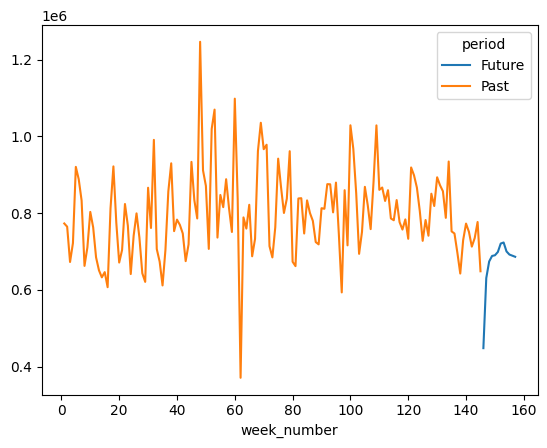

In [39]:
df.groupby(["week_number", "period"]).num_orders.sum().unstack().plot()

In [40]:
import matplotlib.pyplot as plt

In [41]:
def plot_demand_for_meal(meal_name):
    df[df.meal_name == meal_name].groupby(["week_number", "period"]).num_orders.sum().unstack().plot(title=meal_name)
    plt.show()

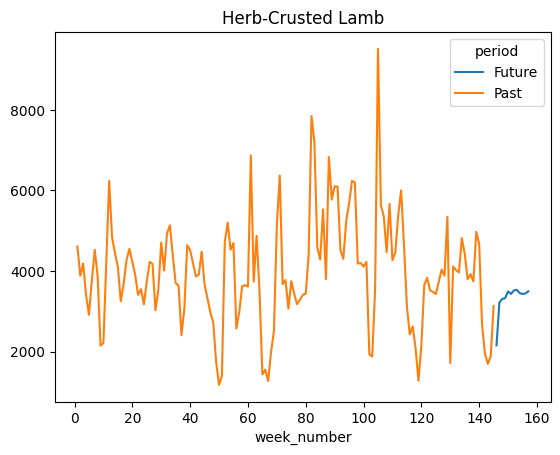

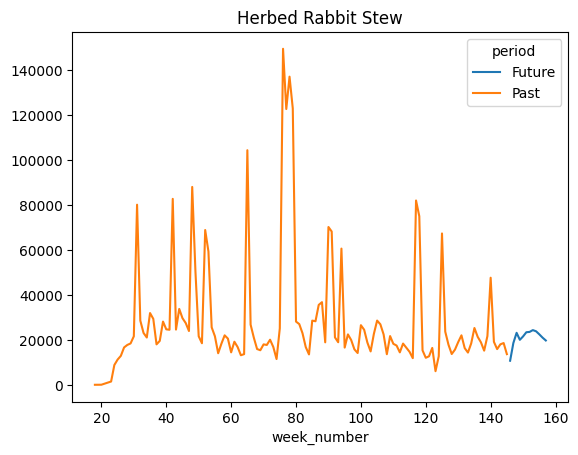

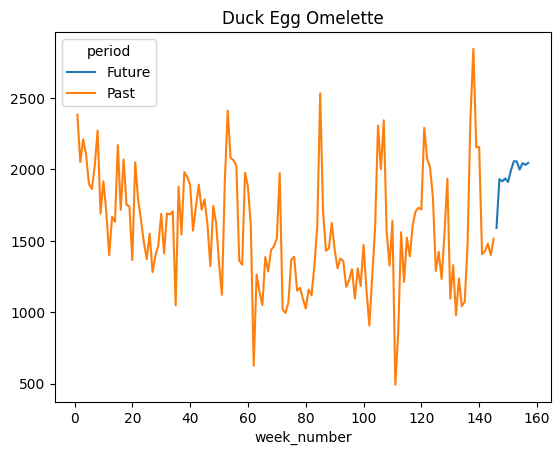

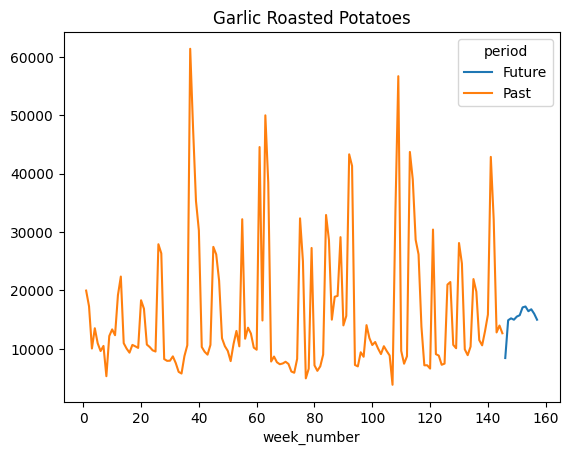

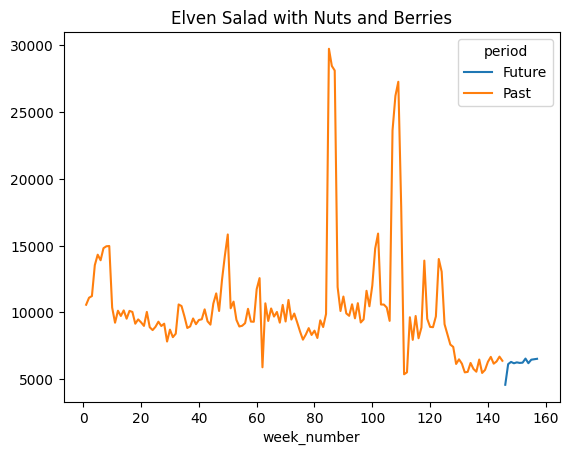

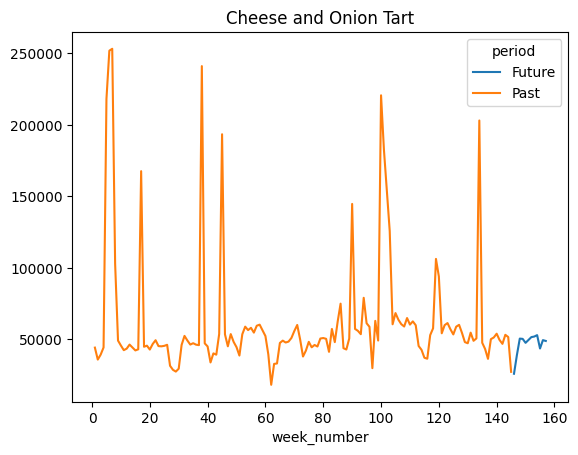

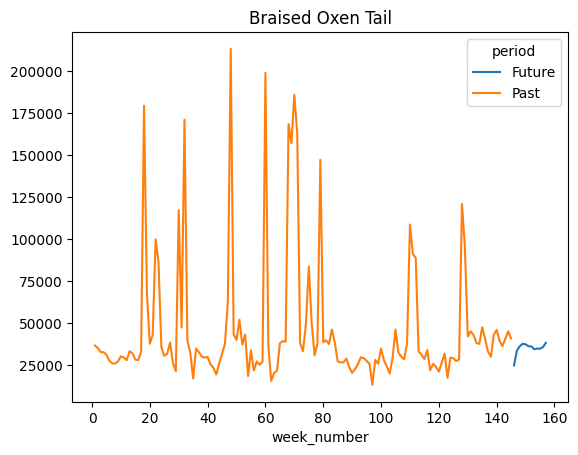

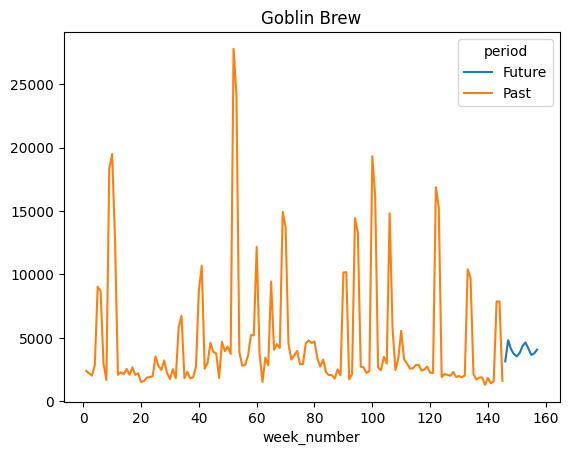

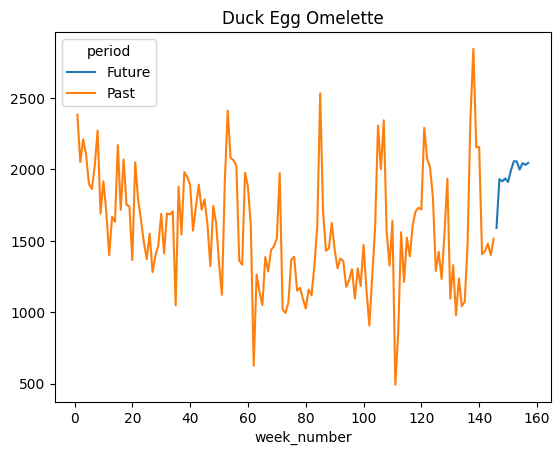

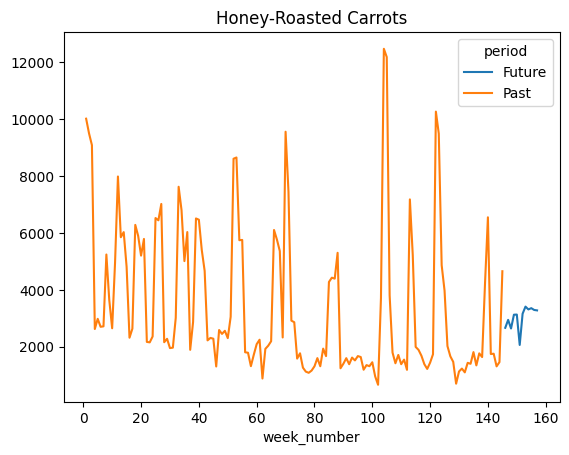

In [42]:
for meal_name in df.meal_name.sample(10):
    plot_demand_for_meal(meal_name)

In [43]:
def plot_demand_for_meal_segment(segment_name, segment_value):
    df[df[segment_name] == segment_value].groupby(["week_number", "period"]).num_orders.sum().unstack().plot(title=f"{segment_name} = {segment_value}")
    plt.show()

In [44]:
df[["meal_type", "meal_category"]].value_counts().index.tolist()

[('main', 'Meat'),
 ('starter', 'Vegetarian'),
 ('dessert', 'Other'),
 ('starter', 'Other'),
 ('main', 'Vegetarian'),
 ('main', 'Seafood'),
 ('beverage', 'Other'),
 ('side', 'Vegetarian'),
 ('starter', 'Seafood'),
 ('starter', 'Meat')]

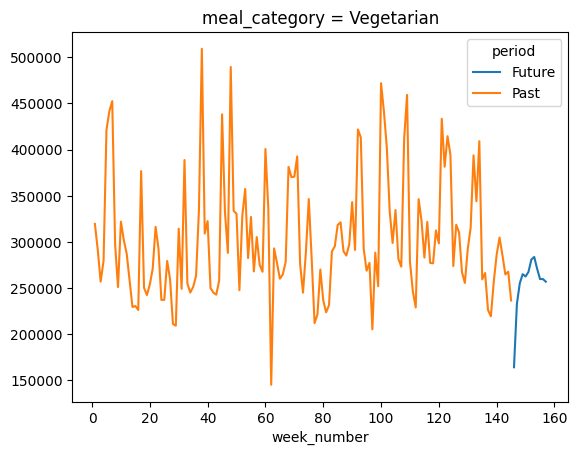

In [45]:
plot_demand_for_meal_segment("meal_category", "Vegetarian")

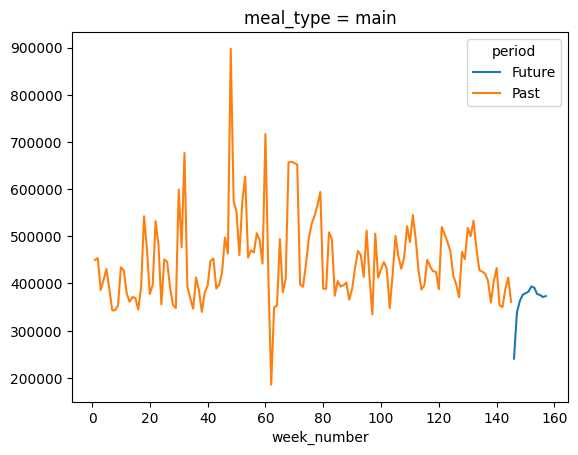

In [46]:
plot_demand_for_meal_segment("meal_type", "main")

225644


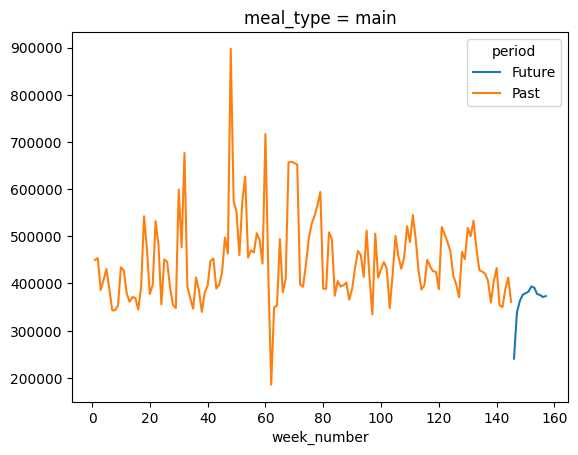

150406


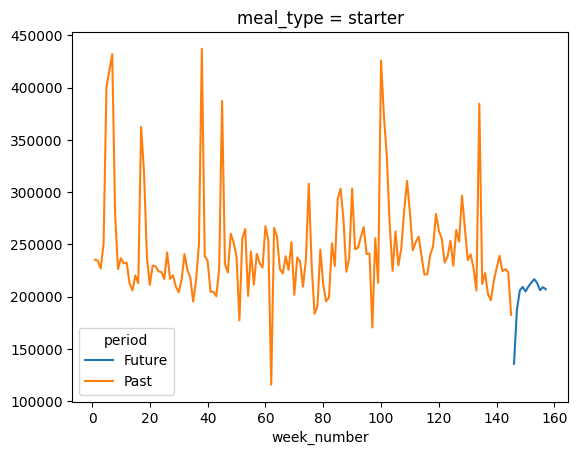

41545


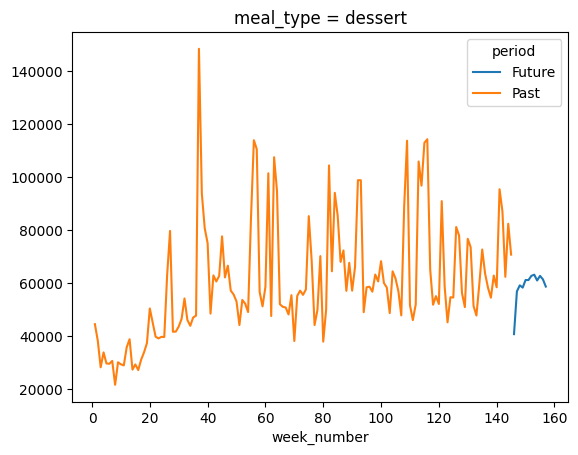

34560


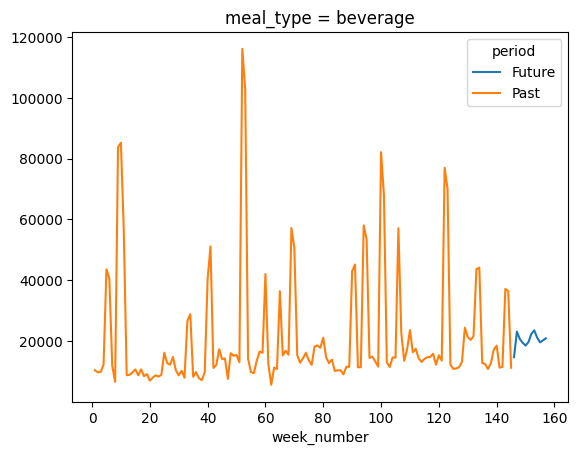

32785


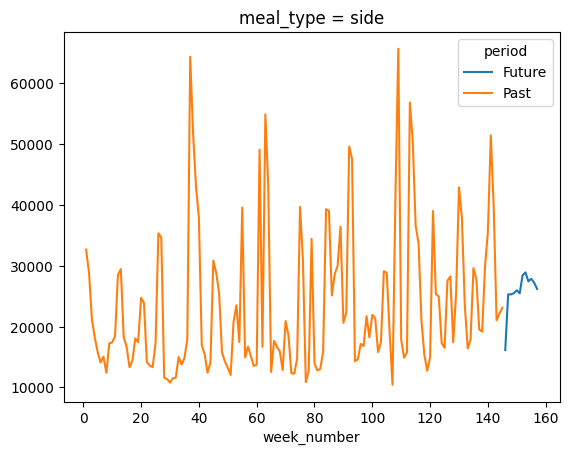

In [47]:
for mt, vc in df.meal_type.value_counts().reset_index().values.tolist():
    print(vc)
    plot_demand_for_meal_segment("meal_type", mt)

166659


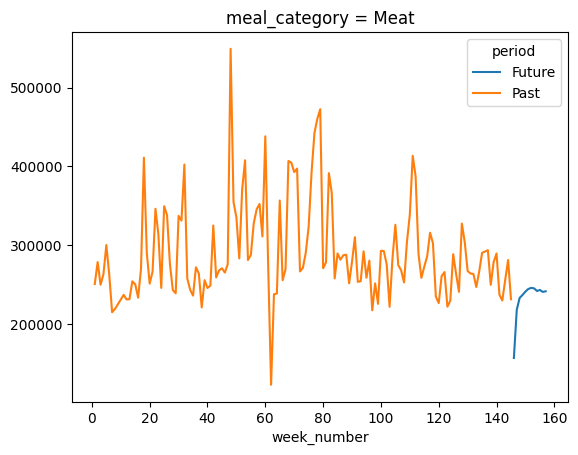

156380


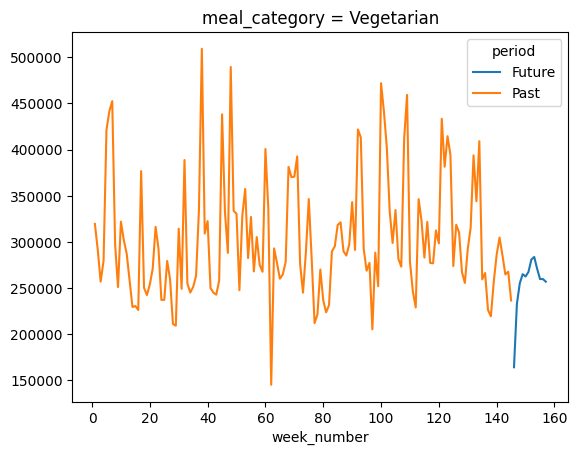

115525


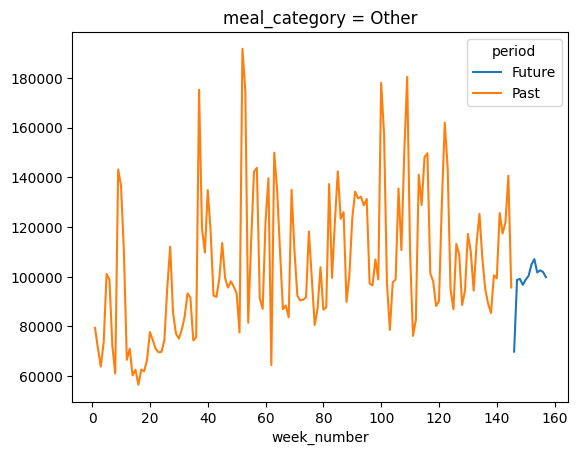

46376


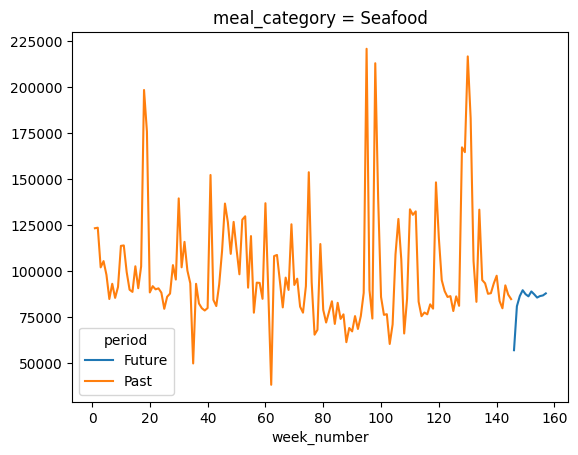

In [48]:
for mc, vc in df.meal_category.value_counts().reset_index().values.tolist():
    print(vc)
    plot_demand_for_meal_segment("meal_category", mc)

## 4. Upload to Postgres

In [53]:
!rm -r ../postgres_data

In [54]:
!mkdir -p ../postgres_data

In [55]:
!ls ../

LICENSE          artifacts        data             postgres_data
README.md        assets           model            requirements.txt
api              dashboard        notebooks        venv


In [56]:
!docker ps | grep postgres

In [75]:
!docker run --name ml-quest-postgres \
    --rm -d \
    -e POSTGRES_HOST_AUTH_METHOD=trust \
    -p 5432:5432 \
    -v ./../postgres_data:/var/lib/postgresql/data \
    postgres:13

0cfd4aca2f551ae033cff149a548e553463d1cca2dce22440c30a8949779efe5


In [58]:
!docker ps | grep postgres

5138de93421c   postgres:13   "docker-entrypoint.s…"   4 seconds ago   Up 3 seconds   0.0.0.0:5432->5432/tcp   ml-quest-postgres


In [59]:
import pandas as pd
import psycopg2
from psycopg2 import sql

def upload_to_postgres(df, table_name, dbname="postgres", user="postgres", host='localhost', port=5432):
    # Connect to PostgreSQL
    conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port)
    cur = conn.cursor()
    
    # Create table if it doesn't exist
    create_table_query = sql.SQL("""
        CREATE TABLE IF NOT EXISTS {table} (
            {fields}
        )
    """).format(
        table=sql.Identifier(table_name),
        fields=sql.SQL(', ').join(
            sql.SQL("{} {}").format(sql.Identifier(col), sql.SQL(pandas_to_postgres_type(str(df[col].dtype)))) for col in df.columns
        )
    )
    cur.execute(create_table_query)
    conn.commit()

    # Insert data into table
    for index, row in df.iterrows():
        insert_query = sql.SQL("""
            INSERT INTO {table} ({fields}) VALUES ({values})
        """).format(
            table=sql.Identifier(table_name),
            fields=sql.SQL(', ').join(map(sql.Identifier, df.columns)),
            values=sql.SQL(', ').join(sql.Placeholder() * len(df.columns))
        )
        cur.execute(insert_query, tuple(row))
    
    conn.commit()
    cur.close()
    conn.close()

def pandas_to_postgres_type(dtype):
    if dtype == 'int64':
        return 'INTEGER'
    elif dtype == 'float64':
        return 'FLOAT'
    elif dtype == 'bool':
        return 'BOOLEAN'
    else:
        return 'TEXT'



In [62]:
df = df.drop(columns=["meal_info"])

In [63]:
upload_to_postgres(df, "current_meal_demand")

In [64]:
def run_query(query, fetch=True, dbname="postgres", user="postgres", host='localhost', port=5432):
    # Connect to PostgreSQL
    conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port)
    cur = conn.cursor()

    # Execute the SELECT query
    cur.execute(query)
    
    if fetch:
        # Fetch the results
        rows = cur.fetchall()
        colnames = [desc[0] for desc in cur.description]

        # Close the cursor and connection
        cur.close()
        conn.close()

        # Convert to DataFrame
        df = pd.DataFrame(rows, columns=colnames)
        
        return df


In [77]:
run_query("select * from current_meal_demand limit 10 offset 10")

,week_number,num_orders,meal_info,period,current_week,city_name,meal_name,meal_category,meal_type
0,1,823.0,None,Past,146,Brackenbury,Wild Boar Ribs,Meat,main
1,1,972.0,None,Past,146,Brackenbury,Pan-Seared Salmon,Seafood,main
2,1,162.0,None,Past,146,Brackenbury,Cheese and Onion Tart,Vegetarian,starter
3,1,420.0,None,Past,146,Brackenbury,Spit-Roasted Quail,Meat,main
4,1,756.0,None,Past,146,Brackenbury,Fish and Chips,Seafood,main
5,1,108.0,None,Past,146,Brackenbury,Dwarven Ale Bread,Other,starter
6,1,28.0,None,Past,146,Brackenbury,Honey-Roasted Carrots,Vegetarian,side
7,1,28.0,None,Past,146,Brackenbury,Herb-Crusted Lamb,Meat,main
8,1,188.0,None,Past,146,Brackenbury,Crab Cakes with Lemon Butter,Seafood,starter
9,1,485.0,None,Past,146,Brackenbury,Braised Oxen Tail,Meat,main


In [78]:
run_query("""
    select
        t.*,
        rank() over (order by t.total_forecasted_orders desc)
    from (
        select city_name, meal_name, sum(num_orders) as total_forecasted_orders
        from current_meal_demand
        where period = 'Future'
        group by city_name, meal_name
        order by total_forecasted_orders desc
        limit 10
    ) t
""")

,city_name,meal_name,total_forecasted_orders,rank
0,Briarwood,Mushroom Stew,27104.415198,1
1,Briarwood,Cheese and Onion Tart,25213.174703,2
2,Kingsholm,Cheese and Onion Tart,24694.864311,3
3,Invermere,Mushroom Stew,22672.746152,4
4,Kingsholm,Mushroom Stew,22626.256257,5
5,Greenshade,Cheese and Onion Tart,22419.588225,6
6,Stormwatch,Mushroom Stew,22037.263395,7
7,Tanglewood,Mushroom Stew,21710.150546,8
8,Briarwood,Fish and Chips,21088.554353,9
9,Mirthwood,Mushroom Stew,19259.040156,10


In [68]:
from datetime import datetime

In [69]:
run_query(f"""
CREATE TABLE IF NOT EXISTS current_meal_demand_metadata (
    updated_date date
);
INSERT INTO current_meal_demand_metadata values ('{datetime.now().date().isoformat()}');
COMMIT;
""", fetch=False)

In [79]:
run_query("select * from current_meal_demand_metadata;")

,updated_date
0,2024-08-10


In [71]:
!docker ps | grep postgres

5138de93421c   postgres:13   "docker-entrypoint.s…"   6 minutes ago   Up 6 minutes   0.0.0.0:5432->5432/tcp   ml-quest-postgres


In [80]:
!docker stop ml-quest-postgres

ml-quest-postgres


In [81]:
!docker ps | grep postgres

In [82]:
!ls ../postgres_data/

PG_VERSION           pg_multixact         pg_tblspc
base                 pg_notify            pg_twophase
global               pg_replslot          pg_wal
pg_commit_ts         pg_serial            pg_xact
pg_dynshmem          pg_snapshots         postgresql.auto.conf
pg_hba.conf          pg_stat              postgresql.conf
pg_ident.conf        pg_stat_tmp          postmaster.opts
pg_logical           pg_subtrans


## 5. Dashboard Playground

In [83]:
df

,week_number,num_orders,period,current_week,city_name,meal_name,meal_category,meal_type
0,1,177.000000,Past,146,Brackenbury,Mushroom Stew,Vegetarian,main
1,1,270.000000,Past,146,Brackenbury,Dwarven Meat Pie,Meat,main
2,1,189.000000,Past,146,Brackenbury,Dragonfire Chili,Meat,main
3,1,54.000000,Past,146,Brackenbury,Stuffed Mushrooms,Vegetarian,starter
4,1,40.000000,Past,146,Brackenbury,Grilled Trout with Lemon,Seafood,main
...,...,...,...,...,...,...,...,...
484935,157,80.122276,Future,146,Meadowbrook,Fire-Grilled Venison,Meat,main
484936,157,39.574436,Future,146,Meadowbrook,Forest Berry Pie,Other,dessert
484937,157,260.000607,Future,146,Meadowbrook,Savory Meat Pies,Meat,main
484938,157,368.016931,Future,146,Meadowbrook,Apple and Raisin Bread,Other,dessert


In [109]:
(
    df
    .groupby(["city_name", "meal_name", "week_number"])
    .num_orders.sum()
    .unstack()
    .fillna(0)
    .astype(int)
    .reset_index()
)


week_number,city_name,meal_name,1,2,3,4,5,6,7,8,...,148,149,150,151,152,153,154,155,156,157
0,Aldershade,Apple and Raisin Bread,0,0,0,0,0,0,0,0,...,312,268,301,334,290,288,286,300,300,287
1,Aldershade,Baked Apple with Cinnamon,540,512,350,312,150,284,297,80,...,434,494,461,544,552,596,585,582,461,448
2,Aldershade,Baked Potato with Chives,783,960,836,1216,811,649,729,1000,...,380,419,414,438,481,458,464,437,387,406
3,Aldershade,Barley and Mushroom Risotto,28,13,55,53,68,13,41,28,...,105,103,98,101,98,98,98,96,96,101
4,Aldershade,Basil and Tomato Soup,446,230,0,149,204,94,177,14,...,122,130,129,128,120,133,132,142,146,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3542,Zephyrvale,Spit-Roasted Quail,312,176,285,285,960,904,323,271,...,351,370,374,379,340,376,376,416,380,385
3543,Zephyrvale,Stuffed Mushrooms,40,54,28,41,55,0,26,0,...,62,64,67,65,61,62,62,65,64,66
3544,Zephyrvale,Vegetable Stir-Fry,1041,311,162,312,109,95,108,82,...,250,304,328,343,490,354,249,255,243,221
3545,Zephyrvale,Venison Jerky,68,297,109,28,108,26,0,53,...,63,69,68,67,64,67,62,71,66,67


In [110]:

top_cities_df = (
    df.groupby("city_name")["num_orders"]
    .sum()
    .reset_index()
    .sort_values(by="num_orders", ascending=False)
    .head(10)
)

In [111]:
top_cities_df

,city_name,num_orders
5,Briarwood,4.514325e+06
33,Kingsholm,3.926077e+06
22,Greenshade,3.589774e+06
26,Invermere,3.322274e+06
39,Mirthwood,3.186508e+06
57,Stormwatch,2.979040e+06
58,Tanglewood,2.947573e+06
0,Aldershade,2.941334e+06
59,Thornfield,2.537498e+06
50,Quicksilver,2.410649e+06


In [113]:


top_cities_df["orders"] = top_cities_df.city_name.apply(
    lambda city_name: df[df.city_name == city_name]
    .groupby("week_number")  # pyright: ignore
    .num_orders.sum()
    .sort_index()
    .tolist()
)


In [114]:
top_cities_df

,city_name,num_orders,orders
5,Briarwood,4.514325e+06,"[29531.0, 24107.0, 26816.0, 28167.0, 26897.0, ..."
33,Kingsholm,3.926077e+06,"[25595.0, 27744.0, 23529.0, 27540.0, 23094.0, ..."
22,Greenshade,3.589774e+06,"[25327.0, 21561.0, 22411.0, 22794.0, 22354.0, ..."
26,Invermere,3.322274e+06,"[18318.0, 19280.0, 17420.0, 17608.0, 18528.0, ..."
39,Mirthwood,3.186508e+06,"[21570.0, 20620.0, 18749.0, 18187.0, 19907.0, ..."
57,Stormwatch,2.979040e+06,"[17168.0, 16857.0, 16392.0, 16338.0, 15808.0, ..."
58,Tanglewood,2.947573e+06,"[21636.0, 20134.0, 17950.0, 20439.0, 19203.0, ..."
0,Aldershade,2.941334e+06,"[17595.0, 17250.0, 14392.0, 17516.0, 16269.0, ..."
59,Thornfield,2.537498e+06,"[14535.0, 15747.0, 13004.0, 15996.0, 14739.0, ..."
50,Quicksilver,2.410649e+06,"[17075.0, 16146.0, 14188.0, 16629.0, 13779.0, ..."
